In [1]:
%load_ext autoreload
%autoreload 2

In [7]:

import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from  matplotlib.patches import Polygon
from IPython.display import Image
import imageio.v2
import csv

import tqdm as tqdm
import jax 


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

from iLQR import RefPath
from iLQR import iLQR
# from iLQR import iLQRnp as iLQR



In [5]:
def load_path(filepath: str):
    """
    Gets the centerline of the track from the trajectory data. We currently only
    support 2D track.

    Args:
        filepath (str): the path to file consisting of the centerline position.

    Returns:
        np.ndarray: centerline, of the shape (2, N).
    """
    x = []
    y = []
    with open(filepath) as f:
        spamreader = csv.reader(f, delimiter=',')
        for i, row in enumerate(spamreader):
            if i > 0:
                x.append(float(row[0]))
                y.append(float(row[1]))

    return np.array([x, y])

In [22]:
a = np.random.random(5)
b = np.random.random((5,2,2))

np.tensordot(a,b, axes=0).shape






(5, 5, 2, 2)

iLQR setting: iLQR config: {'num_dim_x': 5, 'num_dim_u': 2, 'T': 10, 'dt': 0.1, 'platform': 'cpu', 'max_iter': 50, 'tol': 0.05, 'line_search_base': 0.1, 'line_search_a': -1, 'line_search_b': 3, 'line_search_c': 1, 'reg_min': 1e-05, 'reg_max': 100000000.0, 'reg_scale_down': 5, 'reg_scale_up': 5, 'reg_init': 1.0, 'max_attempt': 5, 'wheelbase': 0.257, 'radius': 0.13, 'width': 0.22, 'length': 0.4, 'delta_max': 0.35, 'delta_min': -0.35, 'v_max': 5.0, 'v_min': 0.0, 'omega_min': -6.0, 'omega_max': 6.0, 'a_max': 5.0, 'a_min': -5.0, 'v_ref': 1.0, 'dim_closest_pt_x': 0, 'dim_closest_pt_y': 1, 'dim_path_slope': 2, 'path_cost_type': 'quadratic', 'path_weight': 5.0, 'path_huber_delta': 2, 'vel_cost_type': 'quadratic', 'vel_weight': 2.0, 'vel_huber_delta': 1, 'dim_vel_limit': 3, 'vel_limit_a': 10.0, 'vel_limit_b': 1.0, 'heading_cost_type': 'quadratic', 'heading_weight': 1, 'heading_huber_delta': 1, 'lat_accel_thres': 6.0, 'lat_accel_a': 5.0, 'lat_accel_b': 2.0, 'dim_progress': 4, 'progress_weight': 

Text(0.5, 1.0, 'Lateral Acceleration')

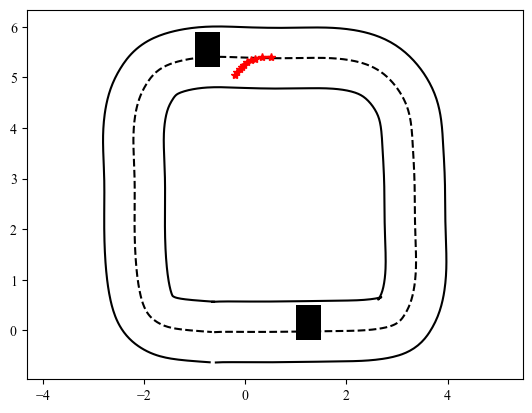

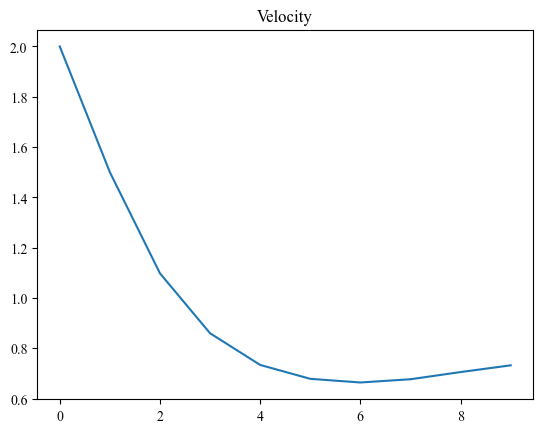

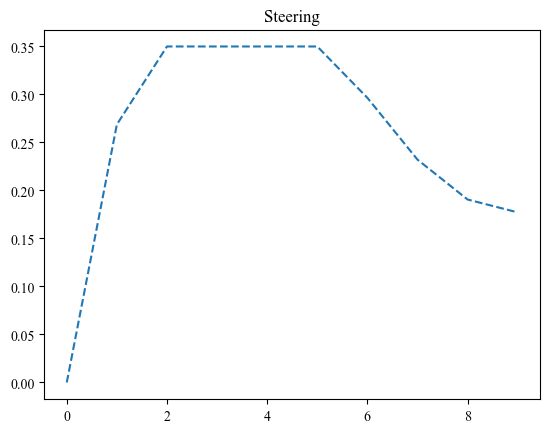

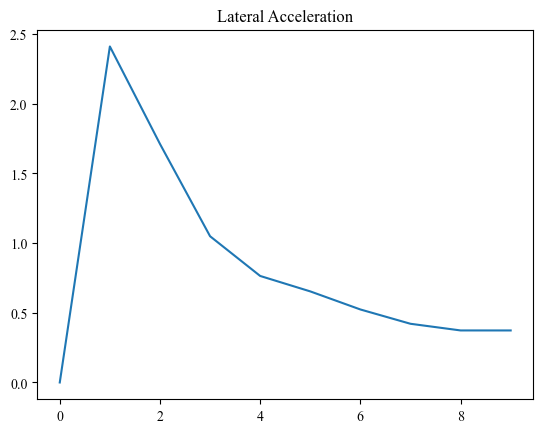

In [28]:

centerline = load_path('outerloop_center_smooth.csv')
path = RefPath(centerline, 0.6, 0.6, 2, loop=False)
config_file = '/hdd/Git_Repo/PrincetonRaceCar/ROS_Core/src/Planning/ilqr_planning_ros/configs/ilqr.yaml'
solver = iLQR()#config_file)
# # make some obstacles
# obs1 = np.array([[-1, -1, -0, -0], [5.2, 6.0, 6.0, 5.2]]).T
obs1 = np.array([[-1, -1, -0.5, -0.5], [5.2, 5.9, 5.9, 5.2]]).T
obs2 = np.array([[1, 1, 1.5, 1.5], [-0.2, 0.5, 0.5, -0.2]]).T
obs_list = [[obs1 for _ in range(10)]]#, [obs2 for _ in range(10)]]
solver.update_obstacles(obs_list)
solver.update_ref_path(path)

x_cur = np.array([0.5, 5.4, 2, 3.14, 0])

plan = solver.plan(x_cur, verbose=True)

path.plot_track()
path.plot_track_center()
plt.plot(plan['trajectory'][0, :], plan['trajectory'][1, :], 'r-*', linewidth=2)


p = Polygon(obs1, facecolor = 'k')
plt.gca().add_patch(p)
plt.axis('equal')

p = Polygon(obs2, facecolor = 'k')
plt.gca().add_patch(p)
plt.axis('equal')

plt.figure()
a = plan['trajectory'][2, :] 
plt.plot(a)
plt.title('Velocity')

plt.figure()
# plt.plot(plan['controls'][0,:])
plt.plot(plan['trajectory'][-1,:], '--')
plt.title('Steering')

plt.figure()
a = plan['trajectory'][2, :]**2 / 0.257 * np.tan(plan['trajectory'][-1, :])
plt.plot(a)
plt.title('Lateral Acceleration')



In [ ]:
x_cur = np.array([0., 0., 0, 0., 0.])  # Initial state.

# Load ILQR
centerline = load_path('outerloop_center_smooth.csv')
path = RefPath(centerline, 0.6, 0.6, 2, loop=False)

config_file = '/hdd/Git_Repo/PrincetonRaceCar/ROS_Core/src/Planning/ilqr_planning_ros/configs/ilqr.yaml'
solver = iLQR() #(config_file)
solver.update_ref_path(path)

obs1 = np.array([[-1, -1, -0.5, -0.5], [5.3, 5.8, 5.8, 5.3]]).T
obs2 = np.array([[1, 1.25, 1.5, 1.5, 1.25, 1], [5.2, 4.8, 5.2 , 5.4, 5.6, 5.4]]).T
obs3 = np.array([[2.5, 2.5, 2, 2], [-0, 0.5, 0.5, -0]]).T
# obs4 = np.array([[-200, -200, -1.5, -1.5], [0.5, 1, 1, 0.5]]).T
obs_list = [[obs1 for _ in range(10)], 
            [obs2 for _ in range(10)],
            [obs3 for _ in range(10)]]
            # [obs4 for _ in range(10)]]
# solver.update_obstacles(obs_list)
# solver.update_obstacles([])

# define some parameters
n = 10
itr_receding = 100
init_control = np.zeros((2, n))
fig_prog_folder = 'fig/'
! mkdir -p $fig_prog_folder

state_history = np.zeros((5,itr_receding))
t_process = np.zeros(itr_receding)
for i in (pbar := tqdm.tqdm(range(itr_receding))):
    
    plan = solver.plan(x_cur, init_control)
    trajectory = plan['trajectory']
    controls = plan['controls']
    x_cur = trajectory[:,1] 
    state_history[:,i]  = x_cur
    init_control[:,:-1] = controls[:,1:]
    pbar.set_description(f"iLQR takes : {plan['t_process']:.2f} sec']")
    t_process[i] = plan['t_process']
    # plot
    plt.clf()
    path.plot_track()
    
    p = Polygon(obs1, facecolor = 'k')
    plt.gca().add_patch(p)

    p = Polygon(obs2, facecolor = 'k')
    plt.gca().add_patch(p)

    p = Polygon(obs3, facecolor = 'k')
    plt.gca().add_patch(p)

    # p = Polygon(obs4, facecolor = 'k')
    # plt.gca().add_patch(p)
    
    sc = plt.scatter(
        state_history[0, :i], state_history[1, :i], s=24,
        c=state_history[2, :i], cmap=cm.jet, vmin=0, vmax=5,
        edgecolor='none', marker='o'
    )
    cbar = plt.colorbar(sc)
    cbar.set_label(r"velocity [$m/s$]", size=20)
    
    plt.plot(trajectory[0, :], trajectory[1, :], 'r', linewidth=2)
    plt.axis('equal')
    plt.savefig(os.path.join(fig_prog_folder, str(i)+".png"), dpi=200)
plt.close('All')

gif_path = os.path.join(fig_prog_folder, 'rollout.gif')
with imageio.get_writer(gif_path, mode='I') as writer:
    for i in range(itr_receding):
        filename = os.path.join(fig_prog_folder, str(i)+".png")
        image = imageio.imread(filename)
        writer.append_data(image)

plt.figure()
plt.plot(state_history[2,:])
plt.title('Velocity')


plt.figure()
a = state_history[2, :]**2 / 0.257 * np.tan(state_history[-1, :])
plt.plot(a)

plt.figure()
plt.plot(t_process)

